# Let's test the model

In [37]:
import tensorflow as tf
import pickle

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
from tensorflow.keras.preprocessing import image

In [39]:
model = tf.keras.models.load_model('models/emotion_model.h5')

with open('models/model_metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

class_names = metadata['class_names']
img_height = metadata['img_height']
img_width = metadata['img_width']

print(f"Model loaded with class names: {class_names}")

Model loaded with class names: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [40]:
test_data_dir = 'raw_data/archive/test'
batch_size = 32

# Create test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    color_mode='grayscale',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False 
)

print(f"Test dataset class names: {test_dataset.class_names}")
print(f"Number of test batches: {len(test_dataset)}")

# Since disgust files are already removed, we can use the dataset directly
test_dataset_filtered = test_dataset

print(f"Using class names: {class_names}")
print(f"Expected classes: {len(class_names)}")
print(f"Dataset classes: {len(test_dataset.class_names)}")


# Verify class alignment
if len(test_dataset.class_names) == len(class_names):
    print("✓ Class names match between model and dataset")
else:
    print("⚠️ Warning: Mismatch between model classes and dataset classes")
    print(f"Model classes: {class_names}")
    print(f"Dataset classes: {test_dataset.class_names}")



Found 7067 files belonging to 6 classes.
Test dataset class names: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of test batches: 221
Using class names: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Expected classes: 6
Dataset classes: 6
✓ Class names match between model and dataset


In [ ]:
# Generate predictions
print("Generating predictions on test set...")
y_true = []
y_pred = []

for images, labels in test_dataset_filtered:
    predictions = model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(f"Total test samples: {len(y_true)}")
print(f"Unique true labels: {np.unique(y_true)}")
print(f"Unique predicted labels: {np.unique(y_pred)}")

accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred, target_names=class_names))

Generating predictions on test set...
Total test samples: 7067
Unique true labels: [0 1 2 3 4 5]
Unique predicted labels: [0 1 2 3 4 5]

Overall Accuracy: 0.5444 (54.44%)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry       0.40      0.58      0.47       958
        fear       0.33      0.25      0.29      1024
       happy       0.82      0.75      0.79      1774
     neutral       0.58      0.39      0.47      1233
         sad       0.39      0.46      0.42      1247
    surprise       0.67      0.77      0.71       831

    accuracy                           0.54      7067
   macro avg       0.53      0.53      0.52      7067
weighted avg       0.56      0.54      0.54      7067



2025-07-19 22:44:01.992032: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


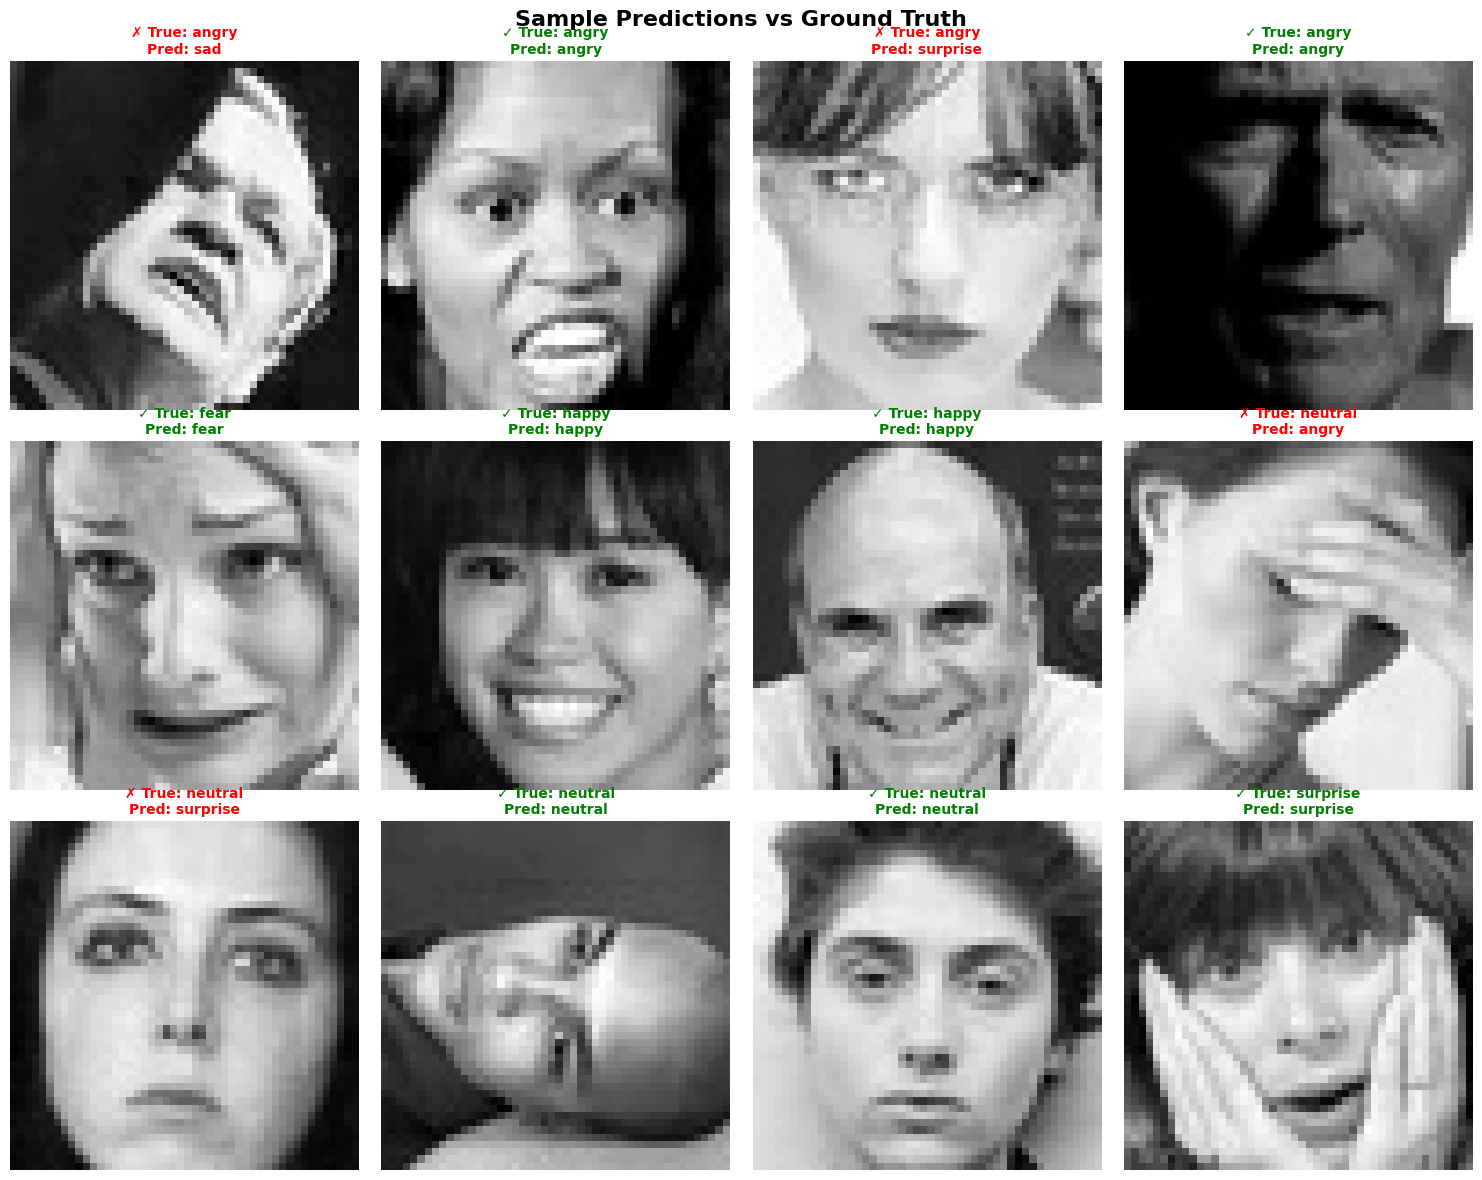

In [42]:
# Show sample predictions
def show_sample_predictions(num_samples=12):
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    fig.suptitle('Sample Predictions vs Ground Truth', fontsize=16, fontweight='bold')
    
    sample_indices = np.random.choice(len(y_true), num_samples, replace=False)
    
    # Get sample images and labels
    sample_images = []
    sample_true = []
    sample_pred = []
    
    current_idx = 0
    for images, labels in test_dataset_filtered:
        for i in range(len(images)):
            if current_idx in sample_indices:
                sample_images.append(images[i].numpy())
                sample_true.append(labels[i].numpy())
                sample_pred.append(y_pred[current_idx])
            current_idx += 1
            if len(sample_images) >= num_samples:
                break
        if len(sample_images) >= num_samples:
            break
    
    for idx in range(num_samples):
        row = idx // 4
        col = idx % 4
        
        # Display image
        axes[row, col].imshow(sample_images[idx].squeeze(), cmap='gray')
        
        # Create title with prediction info
        true_label = class_names[sample_true[idx]]
        pred_label = class_names[sample_pred[idx]]
        
        if sample_true[idx] == sample_pred[idx]:
            title_color = 'green'
            result = '✓'
        else:
            title_color = 'red'
            result = '✗'
        
        title = f"{result} True: {true_label}\nPred: {pred_label}"
        axes[row, col].set_title(title, fontsize=10, color=title_color, fontweight='bold')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

show_sample_predictions()

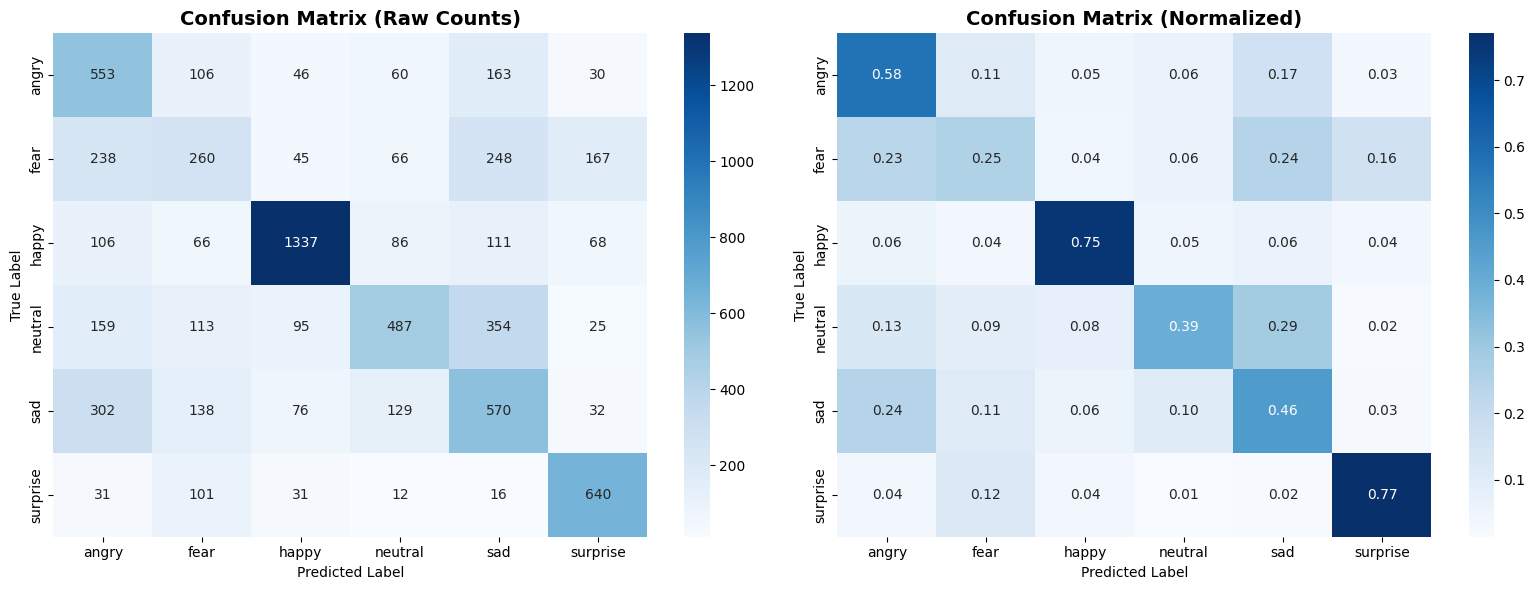


CONFUSION MATRIX ANALYSIS

Class-wise Performance:
----------------------------------------
     angry: Precision=0.398, Recall=0.577, F1=0.471
      fear: Precision=0.332, Recall=0.254, F1=0.288
     happy: Precision=0.820, Recall=0.754, F1=0.786
   neutral: Precision=0.580, Recall=0.395, F1=0.470
       sad: Precision=0.390, Recall=0.457, F1=0.421
  surprise: Precision=0.665, Recall=0.770, F1=0.714


In [43]:
# Generate and plot confusion matrix
def plot_confusion_matrix():
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title('Confusion Matrix (Raw Counts)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    
    # Plot 2: Normalized (percentages)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title('Confusion Matrix (Normalized)', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed confusion matrix analysis
    print("\n" + "="*60)
    print("CONFUSION MATRIX ANALYSIS")
    print("="*60)
    
    print(f"\nClass-wise Performance:")
    print("-" * 40)
    
    for i, class_name in enumerate(class_names):
        true_positives = cm[i, i]
        false_positives = cm[:, i].sum() - true_positives
        false_negatives = cm[i, :].sum() - true_positives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"{class_name:>10}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
    
    return cm

cm = plot_confusion_matrix()